In [91]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier

In [92]:
# create dataset class
class Dataset:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __repr__(self):
        return f"Dataset(x={self.x}, y={self.y})"

    def display(self):
        print(f"x: {self.x}")
        print(f"y: {self.y}")

    def get_data(self):
        return self.x, self.y

In [93]:
def train_weak_classifier(x, y, weights):
    """
    訓練一個弱分類器（決策樹樹樁）並計算其錯誤率和權重。

    :param x: 特徵數據
    :param y: 標籤數據
    :param weights: 樣本權重
    :return: 訓練好的樹樁、predictions、錯誤率和 alpha 值
    """

    # 初始化一個深度為1的決策樹（樹樁）
    stump = DecisionTreeClassifier(max_depth=1)
    # 使用樣本權重進行訓練
    stump.fit(np.array(x).reshape(-1, 1), y, sample_weight=weights)
    # 預測訓練數據
    predictions = stump.predict(np.array(x).reshape(-1, 1))
    # 計算錯誤率
    error = np.sum(weights * (predictions != y))
    
    # 計算 alpha 值
    # 防止錯誤率為 0 或 1 的情況
    if error == 0:
        error = 1e-3
    elif error == 1:
        error = 1 - 1e-3
    else:
        pass

    alpha = 0.5 * np.log((1 - error) / error)
        
    return stump, predictions, error, alpha

def update_weights(weights, alpha, predictions, y):
    """
    更新樣本權重。

    :param weights: 當前樣本權重
    :param alpha: 本輪的 alpha 值
    :param predictions: 樹樁的預測結果
    :param y: 真實標籤
    :return: 更新後的樣本權重
    """
    # 計算新的權重
    new_weights = weights * np.exp(-alpha * np.array(y) * np.array(predictions))

    # 正規化權重
    return new_weights / np.sum(new_weights)

def combined_classifier(x, stumps, alphas):
    """
    結合所有的弱分類器形成最終的強分類器。

    :param x: 特徵數據
    :param stumps: 所有的樹樁s
    :param alphas: 所有的 alpha 值
    :return: 強分類器的預測結果
    """
    final_prediction = np.zeros(len(x))
    # 加權合併所有樹樁的預測
    for stump, alpha in zip(stumps, alphas):
        final_prediction += alpha * stump.predict(np.array(x).reshape(-1, 1))
    # 返回最終的預測結果
    return np.sign(final_prediction)



In [94]:
# 初始資料集
original_dataset = Dataset([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],[1, 1, 1, -1, -1, -1, -1, -1, 1, 1])

# 每一輪的 Boosting Round 資料集
boosting_rounds = {
    "round1": Dataset([0.1, 0.4, 0.5, 0.6, 0.6, 0.7, 0.7, 0.7, 0.8, 0.9], [1, -1, -1, -1, -1, -1, -1, -1, -1, 1]),
    "round2": Dataset([0.1, 0.1, 0.2, 0.2, 0.2, 0.2, 0.3, 0.3, 0.3, 0.3], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
    "round3": Dataset([0.2, 0.3, 0.4, 0.4, 0.4, 0.4, 0.5, 0.6, 0.6, 0.7], [1, 1, -1, -1, -1, -1, -1, -1, -1, -1])
}

# 顯示初始資料集
print("Original Dataset:")
original_dataset.display()

# 顯示每一輪的 Boosting Round 資料集
for key, value in boosting_rounds.items():
    print(f"\nBoosting Round {key}:")
    value.display()



Original Dataset:
x: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
y: [1, 1, 1, -1, -1, -1, -1, -1, 1, 1]

Boosting Round round1:
x: [0.1, 0.4, 0.5, 0.6, 0.6, 0.7, 0.7, 0.7, 0.8, 0.9]
y: [1, -1, -1, -1, -1, -1, -1, -1, -1, 1]

Boosting Round round2:
x: [0.1, 0.1, 0.2, 0.2, 0.2, 0.2, 0.3, 0.3, 0.3, 0.3]
y: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

Boosting Round round3:
x: [0.2, 0.3, 0.4, 0.4, 0.4, 0.4, 0.5, 0.6, 0.6, 0.7]
y: [1, 1, -1, -1, -1, -1, -1, -1, -1, -1]


In [95]:
n_samples = len(original_dataset.x)
weights = np.full(n_samples, 1 / n_samples)

# 顯示初始權重
print('\nInitial Weights:', weights)


stumps = []
errors = []
alphas = []

# 訓練每一輪的弱分類器
# 假設 rounds 是一個包含所有 round 的資料集
for round_name, dataset in boosting_rounds.items():

    x_round = dataset.x
    y_round = dataset.y

    # 訓練弱分類器
    stump, predictions, error, alpha  = train_weak_classifier(x_round, y_round, weights)
    stumps.append(stump)
    errors.append(error)
    alphas.append(alpha)

    # 更新權重
    weights = update_weights(weights, alpha, predictions, y_round)

    print(f"\nRound {round_name}: \nError = {error}, Alpha = {alpha}")
    # print("Weights:", weights)



Initial Weights: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]

Round round1: 
Error = 0.1, Alpha = 1.0986122886681098

Round round2: 
Error = 0.001, Alpha = 3.453377389324277

Round round3: 
Error = 0.001, Alpha = 3.453377389324277


In [102]:
# 結合所有的弱分類器形成最終的強分類器
final_predictions = combined_classifier(original_dataset.x, stumps, alphas)

# show final predictions numpy to int
print(f'預測的y: {final_predictions.astype(int).tolist()}')
print(f'真值的y: {original_dataset.y}')

預測的y: [1, 1, 1, -1, -1, -1, -1, -1, 1, 1]
真值的y: [1, 1, 1, -1, -1, -1, -1, -1, 1, 1]



Stump 1:


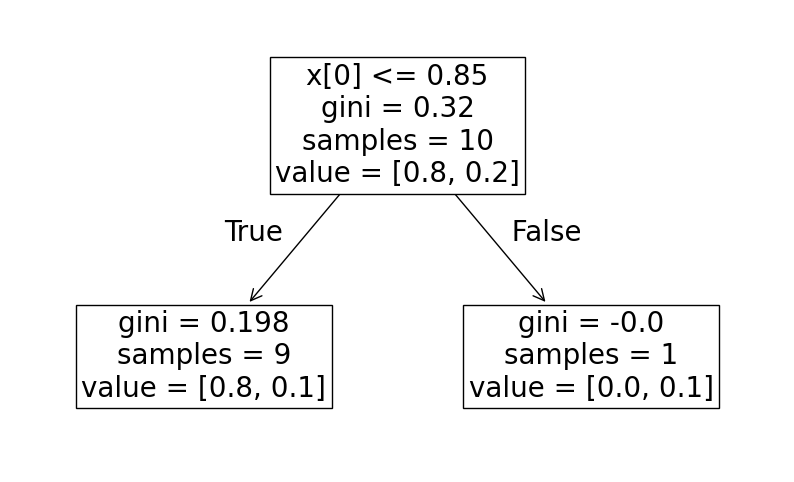


Stump 2:


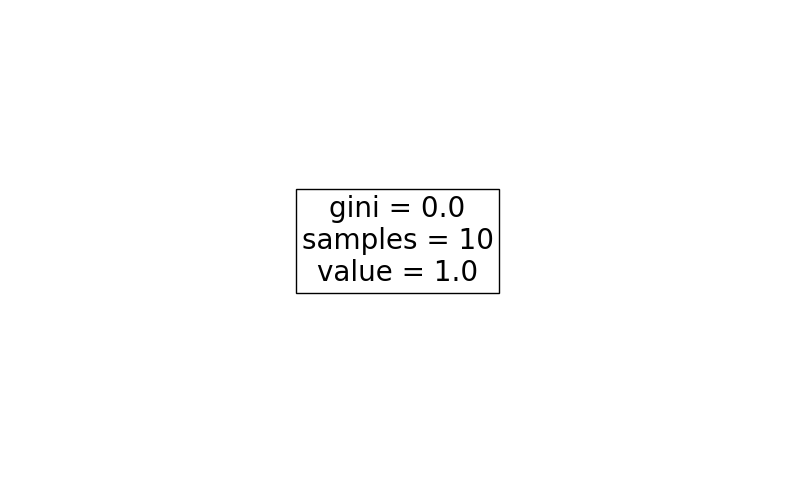


Stump 3:


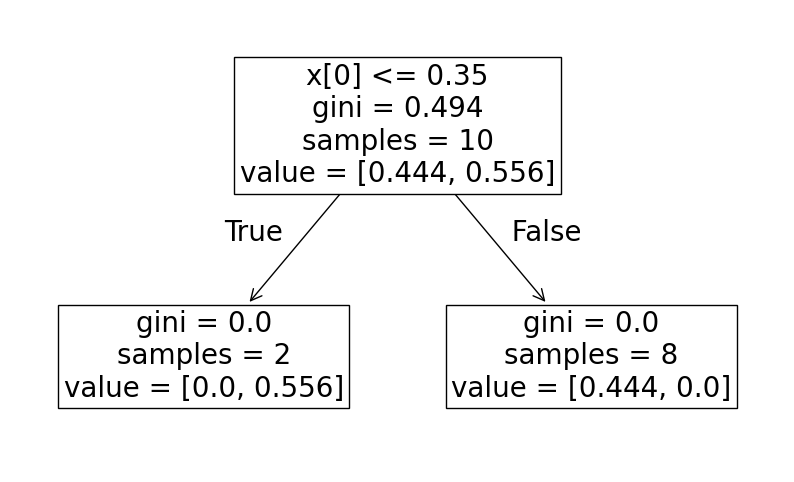

In [97]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# 顯示每個樹樁的詳細資訊
for i, stump in enumerate(stumps):
    print(f"\nStump {i + 1}:")
    plt.figure(figsize=(10,6))
    plot_tree(stump, fontsize=20, class_names=None)
    plt.show()